#This notebook computes the spectrum of the diagonal Jacobian


In [0]:
%%capture
!pip install ipython-autotime
!pip install pytorchcv
!pip install powerlaw
%load_ext autotime

In [0]:
!pip install GPUtil
import GPUtil


GPUtil.showUtilization()

  Created wheel for GPUtil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=63c180a7b1ab62438ce7002b5e6616bb358cd58b68ea45c3adb60d80a0d36561
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built GPUtil
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
time: 4.42 s


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
time: 21.1 s


#change directory into folder with jacobian.py and utils.py

In [0]:
cd /content/drive/My Drive/sketch_J

/content/drive/My Drive/sketch_J
time: 7.58 ms


In [0]:
import pytorchcv
from pytorchcv.model_provider import get_model as ptcv_get_model

import powerlaw
for modelname in pytorchcv.model_provider._models.keys():
    if modelname.startswith('resnet') and modelname.endswith('cifar10'):
        print(modelname)

resnet20_cifar10
resnet56_cifar10
resnet110_cifar10
resnet164bn_cifar10
resnet272bn_cifar10
resnet542bn_cifar10
resnet1001_cifar10
resnet1202_cifar10
time: 3.12 s


In [0]:
from jacobian import *
from utils import *

time: 923 ms


In [0]:
thismodel = 'resnet20_cifar10'
model = ptcv_get_model(thismodel, pretrained=True)
train_dataset, _, train_loader, test_loader = get_data(batch_size=100)
full_J = construct_diagJ(model, train_loader, batch_size=100, device='cuda:0') # The P100 on Colab should have enough memory to do this


Files already downloaded and verified
Files already downloaded and verified
time: 1min 17s


#Clean up Memory

In [0]:
del model
del train_loader
del train_dataset

full_J = full_J.to("cpu")
torch.cuda.empty_cache()
full_J = full_J.to("cuda:0")
#n, _ = full_J.shape
#full_J = 1/n*full_J

M = full_J @ full_J.t() 
del full_J

M = M.to("cpu")
torch.cuda.empty_cache()
M = M.to("cuda:0")

time: 32.1 s


In [0]:
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% | 63% |
time: 341 ms


In [0]:
eigs, dens = slq(M, n_vec=10, m=1000)

Iteration 0 of n_vec
Iteration 1 of n_vec
Iteration 2 of n_vec
Iteration 3 of n_vec
Iteration 4 of n_vec
Iteration 5 of n_vec
Iteration 6 of n_vec
Iteration 7 of n_vec
Iteration 8 of n_vec
Iteration 9 of n_vec
time: 3min 23s


In [0]:
density, grids = density_generate(eigs, dens)

time: 4.28 s


In [0]:
import seaborn as sns
sns.set()

time: 389 ms


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0, 0.5, 'Density (Log Scale)')

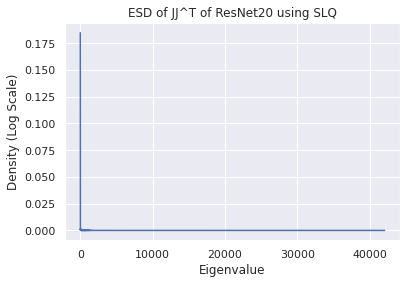

time: 376 ms


In [0]:
plt.plot(grids, density)
plt.title("ESD of JJ^T of ResNet20 using SLQ")
plt.xlabel("Eigenvalue")
plt.ylabel("Density (Log Scale)")